# Importing required python modules:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from matplotlib.colors import ListedColormap
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
%matplotlib inline

# Correlation between the variables

In [3]:
df = pd.read_csv('data_with_WSigLmrkSol.csv',
                 parse_dates=['Date'], index_col='Date')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
ac_levels = {'Issue Reported': {'Crash Urgent': 'Crash',
                                'Crash Service': 'Crash',
                                'COLLISION/PRIVATE PROPERTY': 'Collision',
                                'COLLISION': 'Collision',
                                'COLLISN/ LVNG SCN': 'Collision',
                                'COLLISION WITH INJURY': 'Injury/Fatal',
                                'FLEET ACC/ INJURY': 'Injury/Fatal',
                                'VEHICLE FIRE': 'Injury/Fatal',
                                'TRAFFIC FATALITY': 'Injury/Fatal',
                                'COLLISN / FTSRA': 'Collision',
                                'FLEET ACC/ FATAL': 'Injury/Fatal'}}
df.replace(ac_levels, inplace=True)

In [5]:
ac_values = {'Issue Reported': {'Crash': 1, 'Collision': 2,'Injury/Fatal': 3 }}
df.replace(ac_values, inplace=True)

In [6]:
df.drop(['Accident'], axis=1, inplace=True)

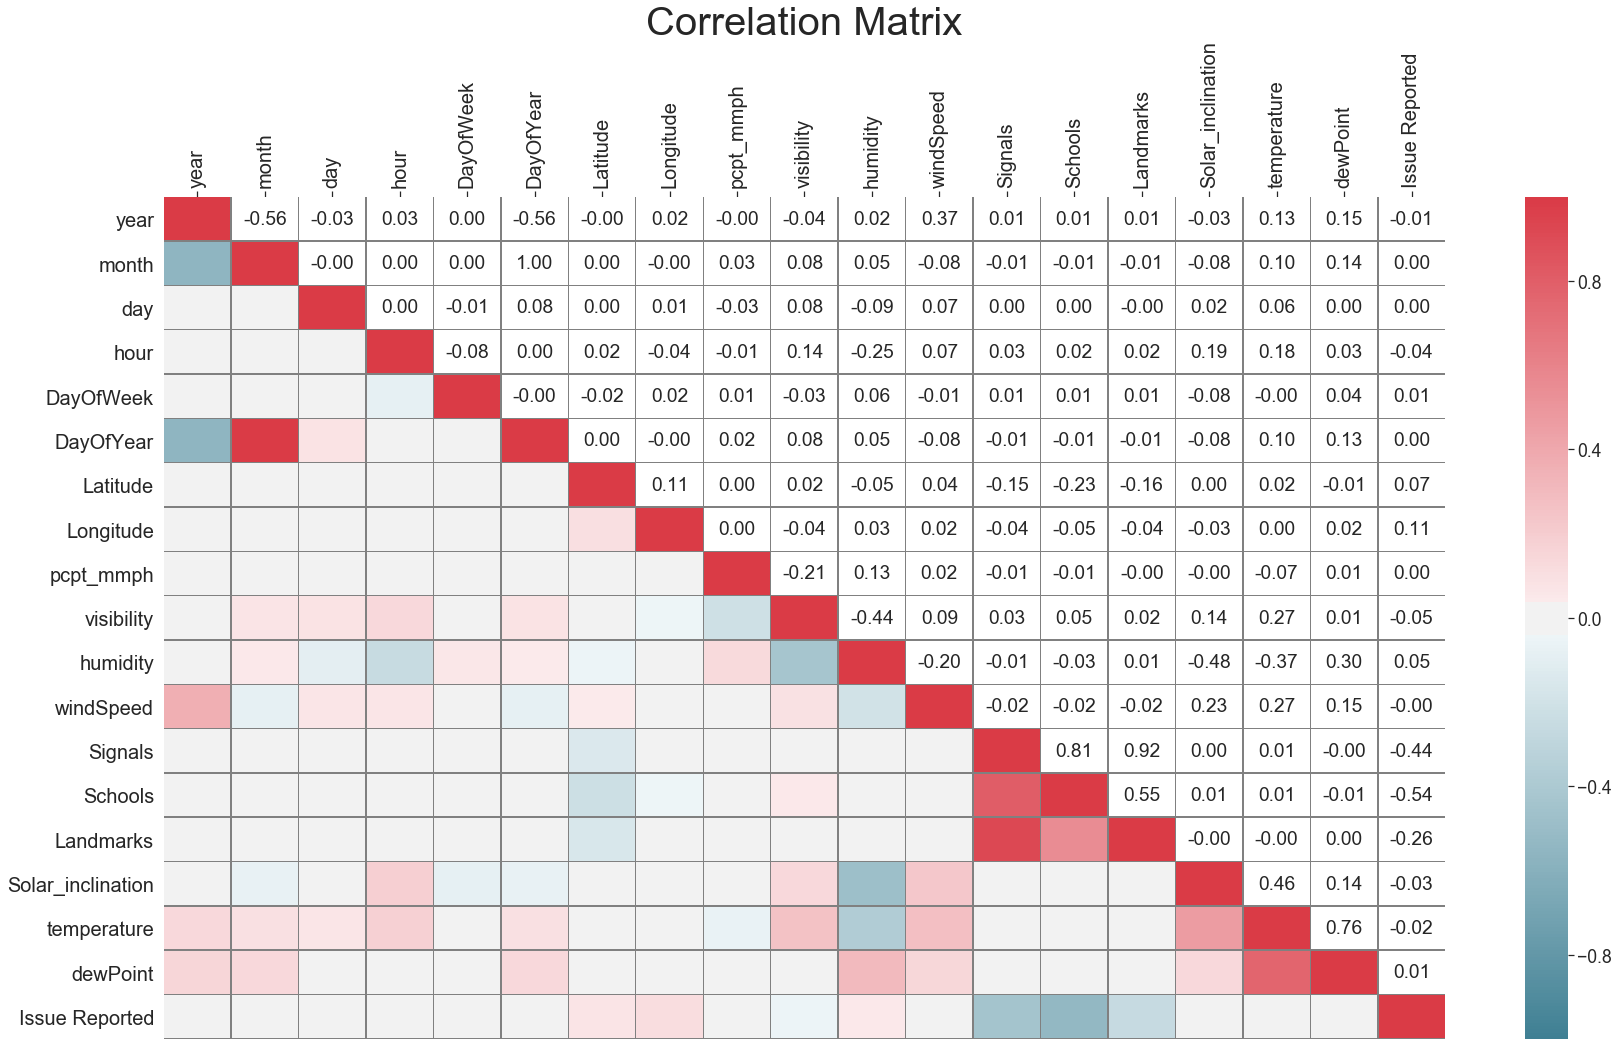

In [8]:
fig, ax = plt.subplots(figsize=(25, 15))
corr = df.corr(method='pearson')
sns.set(font_scale=1.6)
cmap = sns.diverging_palette(220, 10, sep=10, as_cmap=True)
mask1 = np.tril(np.ones(corr.shape)).astype(np.bool)
mask2 = np.ones((19, 19)) - mask1
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=ListedColormap(
     ['White']), annot=True, mask=mask1, cbar=False, square=False, fmt='.2f')
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=False,
                 cmap=cmap, mask=mask2, lw=0.4,
                 linecolor='grey', square=False)
plt.title('Correlation Matrix', fontsize=40)
plt.yticks(fontsize=20)
ax.xaxis.tick_top()
plt.xticks(fontsize=20, rotation=90)
plt.tight_layout()
plt.savefig('correlation_matrix.pdf')

# Daily accident analysis

In [10]:
df0 = pd.read_csv('data_with_WSigLmrkSol.csv', parse_dates=['Date'])
df0.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
df0_date = df0.groupby('Date').sum()['Accident']
df0_month = df0.groupby('month').sum()['Accident']
df0_lat = df0.groupby('Latitude').sum()['Accident']
df0_long = df0.groupby('Longitude').sum()['Accident']
df0_mean = df0_date.mean()
df0_std = df0_date.std()
print('mean: ', round(df0_mean, 3), '\nstandard deviation: ', round(df0_std, 3))

mean:  96.502 
standard deviation:  25.993


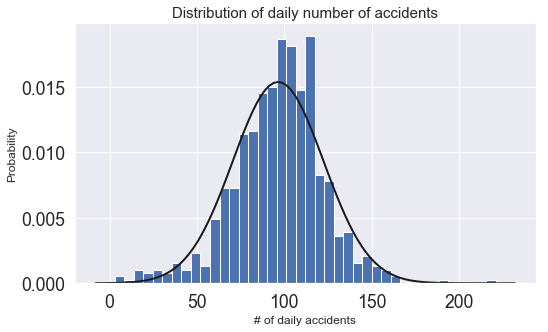

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
df0_date.hist(bins=40, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(df0_date)
# print(mu, std)
p = norm.pdf(x, mu, std)
ax = plt.plot(x, p, 'k', linewidth=2)
# _ = plt.text(0.6,0.9, 'mean = {}, \nstandard deviation = {}'.format(
    # round(df0_mean,2), round(df0_std,2)), size=14, ha='left',
             # va='center', transform=ax.transAxes)
ax = plt.title('Distribution of daily number of accidents', fontsize=15)
ax = plt.xlabel('# of daily accidents', fontsize=12)
ax = plt.ylabel('Probability', fontsize=12)
ax = plt.tight_layout()
plt.savefig('daily_accident_distribution.pdf')

Null Hypothesis: sample mean and sample variance are same as the exact mean and variance of the distribution


Confidence Interval: 
mean: 94.61491537376587 ,  98.42038081805359
std: 24.158103450682145 ,  27.77818081253779
 
p_value(mean):  0.4936
p_value(std):  0.4773


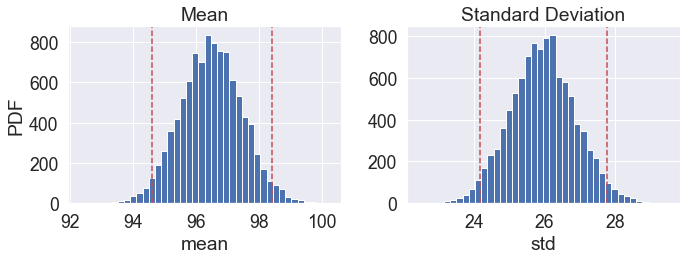

In [17]:


def bootstrap_replicates(data, func):
    bs_samples = np.random.choice(data, len(data))
    return func(bs_samples)

np.random.seed(47)
N_rep = 10000
bs_dailym = np.empty(N_rep)
bs_dailys = np.empty(N_rep)
for i in range(N_rep):
    bs_dailym[i] = bootstrap_replicates(df0_date, np.mean)
    bs_dailys[i] = bootstrap_replicates(df0_date, np.std)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
ax[0].hist(bs_dailym, bins=40)
ax[1].hist(bs_dailys, bins=40)
ax[0].set_xlabel('mean')
ax[1].set_xlabel('std')
ax[0].set_ylabel('PDF')
# ax[1].set_ylabel('PDF')
ax[0].set_title('Mean')
ax[1].set_title('Standard Deviation')
per_dailyx, per_dailyy = np.percentile(bs_dailym, [2.5, 97.5])
per_dailysx, per_dailysy = np.percentile(bs_dailys, [2.5, 97.5])
print('Confidence Interval: \nmean:', per_dailyx, ', ', per_dailyy)
print('std:', per_dailysx, ', ', per_dailysy)
pvaluem = np.sum(bs_dailym >= df0_mean) / N_rep
pvalues = np.sum(bs_dailys >= df0_std) / N_rep
print(' \np_value(mean): ', pvaluem)
print('p_value(std): ', pvalues)
ymin, ymax = plt.ylim()
ax[0].axvline(per_dailyx, color='r', linestyle='--')
ax[0].axvline(per_dailyy, color='r', linestyle='--')
ax[1].axvline(per_dailysx, color='r', linestyle='--')
ax[1].axvline(per_dailysy, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('mean_and_std-daily_accident.pdf')

Since, p-values for mean and standard deviation are both greater than the $\alpha$=0.05, we can accept the null hypothesis. Therefore, we confirmed the normal distribution of the daily accidents in the city. 

p_value(2019 & 2018):  0.4964
p_value(2017 & 2019):  0.5001
p_value(2017 & 2018):  0.5062


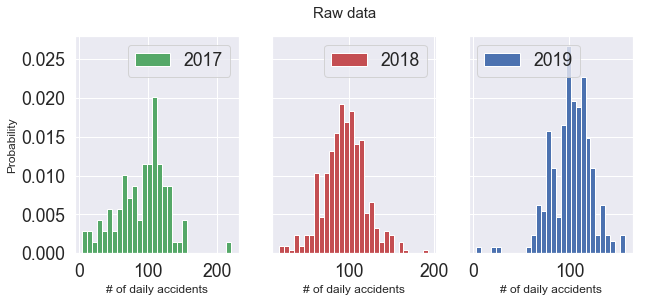

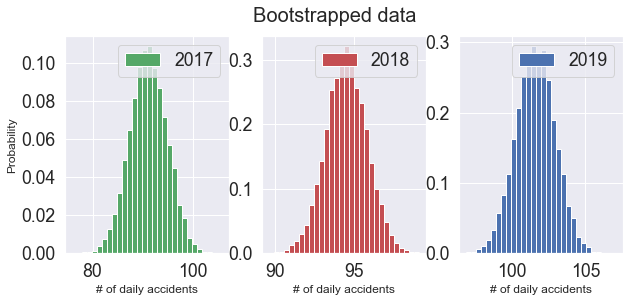

In [20]:
df00 = df0.set_index('Date')['2018']
df01 = df0.set_index('Date')['2019']
df02 = df0.set_index('Date')['2017']

df01_daily = df01.groupby('DayOfYear')['Accident'].sum()
df00_daily = df00.groupby('DayOfYear')['Accident'].sum()
df02_daily = df02.groupby('DayOfYear')['Accident'].sum()
# print('mean: ',round(df00_daily.mean(),3),'\nstandard
     # deviation: ', round(df00_daily.std(),3))
# print('mean: ',round(df01_daily.mean(),3),'\nstandard
     # deviation: ', round(df01_daily.std(),3))
# print('mean: ',round(df02_daily.mean(),3),'\nstandard
     # deviation: ', round(df02_daily.std(),3))
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
fig.suptitle('Raw data', fontsize=15)
ax[1].hist(df00_daily, bins=30, density=True, color='r', label='2018')
ax[2].hist(df01_daily, bins=30, density=True, color='b', label='2019')
ax[0].hist(df02_daily, bins=30, density=True, color='g', label='2017')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[1].set_xlabel('# of daily accidents', fontsize=12)
ax[0].set_xlabel('# of daily accidents', fontsize=12)
ax[2].set_xlabel('# of daily accidents', fontsize=12)
ax[0].set_ylabel('Probability', fontsize=12)
plt.savefig('Raw-daily_accident_threeyears.pdf')
N_rep = 10000
bs1 = np.empty(N_rep)
bs2 = np.empty(N_rep)
bs3 = np.empty(N_rep)
for i in range(N_rep):
    bs1[i] = bootstrap_replicates(df00_daily, np.mean)
    bs2[i] = bootstrap_replicates(df01_daily, np.mean)
    bs3[i] = bootstrap_replicates(df02_daily, np.mean)
bs_diff1 = bs1-bs2
bs_diff2 = bs2-bs3
bs_diff3 = bs3-bs1
bsmean_diff1 = df00_daily.mean() - df01_daily.mean()
bsmean_diff2 = df01_daily.mean() - df02_daily.mean()
bsmean_diff3 = df02_daily.mean() - df00_daily.mean()
p_value1 = np.sum(bs_diff1 >= bsmean_diff1) / N_rep
p_value2 = np.sum(bs_diff2 >= bsmean_diff2) / N_rep
p_value3 = np.sum(bs_diff3 >= bsmean_diff3) / N_rep
print('p_value(2019 & 2018): ', p_value1)
print('p_value(2017 & 2019): ', p_value2)
print('p_value(2017 & 2018): ', p_value3)
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=False)
fig.suptitle('Bootstrapped data', fontsize=20)
ax[1].hist(bs1, bins=30, density=True, color='r', label='2018')
ax[2].hist(bs2, bins=30, density=True, color='b', label='2019')
ax[0].hist(bs3, bins=30, density=True, color='g', label='2017')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[1].set_xlabel('# of daily accidents', fontsize=12)
ax[0].set_xlabel('# of daily accidents', fontsize=12)
ax[2].set_xlabel('# of daily accidents', fontsize=12)
ax[0].set_ylabel('Probability', fontsize=12)
plt.savefig('Bootstrapped-daily_accident_threeyears.pdf')

We separated the distribution of daily accidents into three sets for respective years and calculated the p-values for the difference of each pair and found the p-values greater than $\alpha$=0.05. Therefore, the null hypothesis stating the mean of the distribution of every year originates from the common distribution can be statistically accepted. 







# Latitude and Longitude:

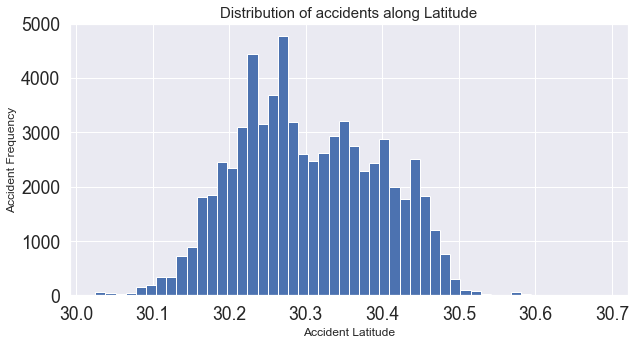

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
df0['Latitude'].hist(bins=50)
# print('mean: ', round(df0_lat.mean(),3), '\nstandard
     # deviation: ', round(df0_lat.std(), 3))
# plt.scatter(df0_lat.index, df0_lat)
_ = plt.title('Distribution of accidents along Latitude', fontsize=15)
_ = plt.xlabel('Accident Latitude', fontsize=12)
_ = plt.ylabel('Accident Frequency', fontsize=12)
plt.savefig('Latitude_accident.pdf')

In [8]:
print('Latitude\nMean: ', df0.Latitude.mean(), 'STD :', df0.Latitude.std())
print('Longitude\nMean: ', df0.Longitude.mean(), 'STD :', df0.Longitude.std())

Latitude
Mean:  30.303356918152588 STD : 0.092938135840743
Longitude
Mean:  -97.73259056270096 STD : 0.08174207518478967


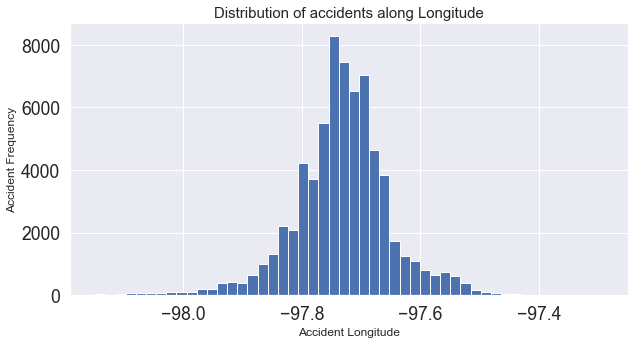

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
df0['Longitude'].hist(bins=50)
_ = plt.title('Distribution of accidents along Longitude', fontsize=15)
_ = plt.xlabel('Accident Longitude', fontsize=12)
_ = plt.ylabel('Accident Frequency', fontsize=12)
# _ = plt.xlim(-98.0, -97.4)
plt.savefig('longitude_accident.pdf')

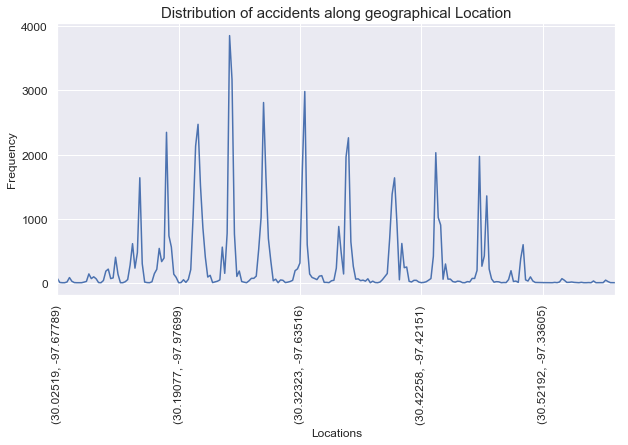

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
df0_loc = df0.groupby('Location')['Accident'].sum().plot()
_ = plt.title('Distribution of accidents along geographical Location', fontsize=15)
_ = plt.xlabel('Locations', fontsize=12)
_ = plt.ylabel('Frequency', fontsize=12)
_ = plt.xticks(fontsize=12, rotation=90)
_ = plt.yticks(fontsize=12)
plt.savefig('location_accident.pdf')

# Trend, Seasonal, Residual Decomposition for time series data:

In [34]:
yy = df0.groupby('Date').sum()[['Accident', 'day']]

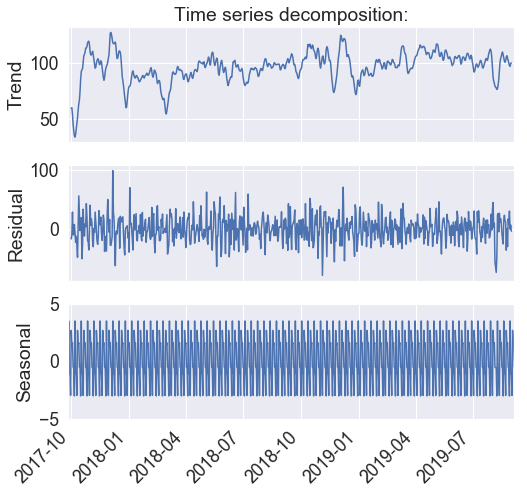

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
decomposition = seasonal_decompose(yy['Accident'], model='additive', freq=10)
decomposition.trend.plot(ax=axes[0])
decomposition.resid.plot(ax=axes[1])
decomposition.seasonal.plot(ax=axes[2], rot=45)
axes[0].set_title('Time series decomposition:')
axes[0].set_ylabel('Trend')
axes[2].set_ylim(-5, 5)
axes[1].set_ylabel('Residual')
axes[2].set_ylabel('Seasonal')
axes[2].set_xlabel('')
plt.savefig('decomposition.pdf')

# Autocorrelation graphs for time series data:

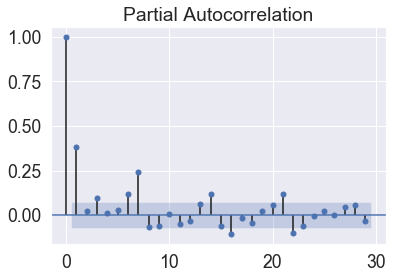

In [99]:
plot_pacf(yy['Accident'], alpha=0.05)
plt.savefig('pacf.pdf')